# 1. data import & preprocessing 

In [2]:
import numpy as np
import pandas as pd

* dataset 불러오기

In [3]:
data25 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/feature25.csv")
data25['is_bump20'] = data25['shortest_bump_dist'] < 20
data25['is_sidewalk12.5'] = data25['shortest_sidewalk_dist'] < 12.5
data25['is_cross100'] = data25['shortest_cross_dist'] < 100
data25['is_signal150'] = data25['shortest_traffic_signal_dist'] < 150

* 1번째 방법: 그냥 그대로

In [4]:
col1 = {"x_common": ['overspeed_cam_count100', 'floating_pop_count50','car_count1000', 'child_count1000', 
                  'elem_kinder_count400','num_cram_school_count400', 
                  'shortest_cross_dist','shortest_traffic_signal_dist'], # 'numberSchoolZone_count400'
       "x_25" : ['is_bump20', 'parking_count12.5','is_sidewalk12.5', 'barrier_nearby_count12.5',
                   'chaos1_nearby_count12.5', 'width_nearby_count12.5','cross_road_nearby_count12.5'],
       "y_25" : 'accident_count12.5'}

xy25 = data25[col1["x_common"] + col1["x_25"] +[col1['y_25']]].astype(float)
xy25[col1['y_25']] = (xy25[col1['y_25']] > 0).astype(float)

* 2번째 방법: 사거리 거리, 신호등 거리 존재여부로 바꿈

In [5]:
col2 = {"x_common": ['overspeed_cam_count100', 'floating_pop_count50','car_count1000', 'child_count1000', 
                  'elem_kinder_count400','num_cram_school_count400', 'is_cross100','is_signal150'], # 'numberSchoolZone_count400'
       "x_25" : ['is_bump20', 'parking_count12.5','is_sidewalk12.5', 'barrier_nearby_count12.5',
                   'chaos1_nearby_count12.5', 'width_nearby_count12.5','cross_road_nearby_count12.5'],
        "y_25" : 'accident_count12.5'}

xy25_my = data25[col2["x_common"] + col2["x_25"] +[col2['y_25']]].astype(float)
xy25_my[col2['y_25']] = (xy25_my[col2['y_25']] > 0).astype(float)

* cluster data 불러오기

In [6]:
kmeans25 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/kmeans_cluster25.csv")

In [7]:
print(xy25.shape)
print(kmeans25.shape)

(7636, 16)
(7636, 1)


* dataset 합치기

In [8]:
xy25=pd.concat([xy25, kmeans25], axis=1)
xy25.rename(columns={'0':'cluster'}, inplace=True)

xy25_my=pd.concat([xy25_my, kmeans25], axis=1)
xy25_my.rename(columns={'0':'cluster'}, inplace=True)

* 사고 방지 장치 데이터 삭제

In [9]:
xy25=xy25.drop(['overspeed_cam_count100', 'is_bump20'], axis=1)
xy25_my=xy25_my.drop(['overspeed_cam_count100', 'is_bump20'], axis=1)

* 열 이름 통일

In [10]:
xy25.rename(columns={'parking_count12.5':'parking_count', 'is_sidewalk12.5':'is_sidewalk',
                    'barrier_nearby_count12.5':'barrier_nearby_count', 'chaos1_nearby_count12.5':'chaos1_nearby_count',
                     'width_nearby_count12.5':'width_nearby_count', 'cross_road_nearby_count12.5':'cross_road_nearby_count',
                     'accident_count12.5':'accident_count'},inplace=True)
xy25_my.rename(columns={'parking_count12.5':'parking_count', 'is_sidewalk12.5':'is_sidewalk',
                    'barrier_nearby_count12.5':'barrier_nearby_count', 'chaos1_nearby_count12.5':'chaos1_nearby_count',
                     'width_nearby_count12.5':'width_nearby_count', 'cross_road_nearby_count12.5':'cross_road_nearby_count',
                     'accident_count12.5':'accident_count'},inplace=True)

* train-test split

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
for train_index, test_index in split.split(xy25, xy25['accident_count']):
    strat_train_set = xy25.loc[train_index]
    strat_test_set = xy25.loc[test_index]

X_train=strat_train_set.drop(['accident_count'], axis=1)
y_train=strat_train_set['accident_count']

X_test=strat_test_set.drop(['accident_count'], axis=1)
y_test=strat_test_set['accident_count']


for train_index, test_index in split.split(xy25_my, xy25_my['accident_count']):
    strat_my_train_set = xy25_my.loc[train_index]
    strat_my_test_set = xy25_my.loc[test_index]

X_my_train=strat_my_train_set.drop(['accident_count'], axis=1)
y_my_train=strat_my_train_set['accident_count']

X_my_test=strat_my_test_set.drop(['accident_count'], axis=1)
y_my_test=strat_my_test_set['accident_count']

# 2. Modeling

### 2-1) XGB Classifier

In [12]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

In [13]:
f1 = make_scorer(f1_score)

In [14]:
xgb=XGBClassifier(scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])

xgb_param_grid={
    'n_estimators':[500, 1000],
    'max_depth':[5, 7, 10],
    'learning_rate':[0.01, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7]
}

xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring=f1, cv=5, n_jobs=-1, verbose=3)
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 26.9min finished
C:\Users\ishon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:09:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=38.3014705882353,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosi

In [15]:
print('best score : {0:.4f}'.format(xgb_grid.best_score_))
print('best param : ', xgb_grid.best_params_)

best score : 0.2157
best param :  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.7}


In [16]:
xgb_model = xgb_grid.best_estimator_
xgb_pred = xgb_model.predict(X_test)

In [17]:
f1_score(y_test, xgb_pred, average=None)

array([0.96580027, 0.23469388])

### feature importance

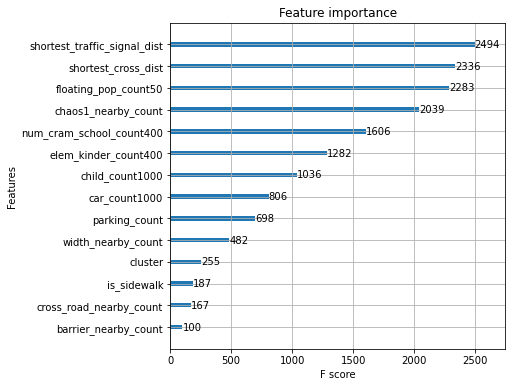

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(xgb_model, ax=ax)

* 사거리, 신호등 변수 처리 후(my)

In [19]:
xgb_my=XGBClassifier(scale_pos_weight=y_my_train.value_counts()[0]/y_my_train.value_counts()[1])

xgb_my_param_grid={
    'n_estimators':[500, 1000],
    'max_depth':[5, 7, 10],
    'learning_rate':[0.01, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7]
}

xgb_my_grid = GridSearchCV(xgb_my, param_grid=xgb_my_param_grid, scoring=f1, cv=5, n_jobs=-1, verbose=3)
xgb_my_grid.fit(X_my_train, y_my_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 22.3min finished
C:\Users\ishon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=38.3014705882353,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosi

In [20]:
print('best score : {0:.4f}'.format(xgb_my_grid.best_score_))
print('best param : ', xgb_my_grid.best_params_)

best score : 0.1715
best param :  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.5}


In [21]:
xgb_my_model = xgb_my_grid.best_estimator_
xgb_my_pred = xgb_my_model.predict(X_my_test)

In [22]:
f1_score(y_my_test, xgb_my_pred, average=None)

array([0.97939068, 0.22033898])

### feature importance

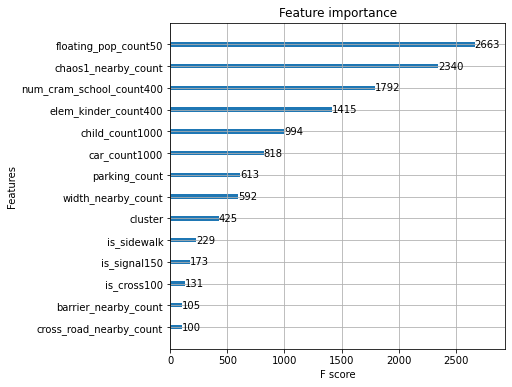

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(xgb_my_model, ax=ax)

### 2-2) LGBM Classifier

In [24]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

* cluster를 categorical type으로 변환

In [25]:
X_train['cluster']=X_train['cluster'].astype('category')
X_test['cluster']=X_test['cluster'].astype('category')

X_my_train['cluster']=X_my_train['cluster'].astype('category')
X_my_test['cluster']=X_my_test['cluster'].astype('category')

In [26]:
lgb = LGBMClassifier(categorical_feature='name:cluster', scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])

lgb_param_grid={
    'learning_rate':[0.01, 0.1],
    'n_estimators':[500,1000],
    'max_depth':[3,7,10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7]
}

lgb_grid = GridSearchCV(lgb, param_grid=lgb_param_grid, scoring=f1, cv=5, n_jobs=-1, verbose=3)
lgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  7.6min finished
C:\Users\ishon\anaconda3\lib\site-packages\lightgbm\basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'
C:\Users\ishon\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5,
             estimator=LGBMClassifier(categorical_feature='name:cluster',
                                      scale_pos_weight=38.3014705882353),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [500, 1000], 'subsample': [0.5, 0.7]},
             scoring=make_scorer(f1_score), verbose=3)

In [27]:
print('best score : {0:.4f}'.format(lgb_grid.best_score_))
print('best param : ', lgb_grid.best_params_)

best score : 0.1866
best param :  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.5}


In [28]:
lgb_model = lgb_grid.best_estimator_
lgb_pred = lgb_model.predict(X_test)

In [29]:
f1_score(y_test, lgb_pred, average=None)

array([0.96982074, 0.24      ])

### feature importance

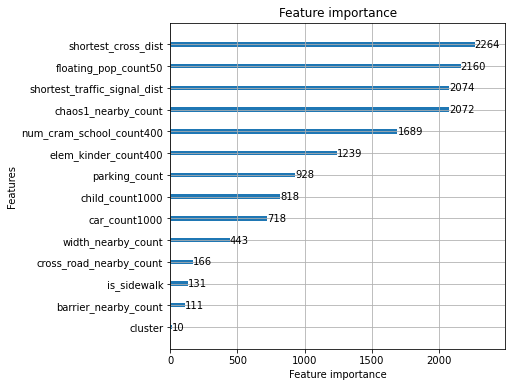

In [30]:
f, ax=plt.subplots(figsize=(6,6))
plot_importance(lgb_model, max_num_features=15, ax=ax) 

* 사거리, 신호등 변수 처리 후(my)

In [31]:
lgb_my = LGBMClassifier(categorical_feature='name:cluster', scale_pos_weight=y_my_train.value_counts()[0]/y_my_train.value_counts()[1])

lgb_my_param_grid={
    'learning_rate':[0.01, 0.1],
    'n_estimators':[500,1000],
    'max_depth':[3,7,10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7]
}

lgb_my_grid = GridSearchCV(lgb_my, param_grid=lgb_my_param_grid, scoring=f1, cv=5, n_jobs=-1, verbose=3)
lgb_my_grid.fit(X_my_train, y_my_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  8.8min finished
C:\Users\ishon\anaconda3\lib\site-packages\lightgbm\basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'
C:\Users\ishon\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5,
             estimator=LGBMClassifier(categorical_feature='name:cluster',
                                      scale_pos_weight=38.3014705882353),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [500, 1000], 'subsample': [0.5, 0.7]},
             scoring=make_scorer(f1_score), verbose=3)

In [32]:
print('best score : {0:.4f}'.format(lgb_my_grid.best_score_))
print('best param : ', lgb_my_grid.best_params_)

best score : 0.1576
best param :  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.5}


In [33]:
lgb_my_model = lgb_my_grid.best_estimator_
lgb_my_pred = lgb_my_model.predict(X_my_test)

In [34]:
f1_score(y_my_test, lgb_my_pred, average=None)

array([0.94476812, 0.18556701])

### feature importance

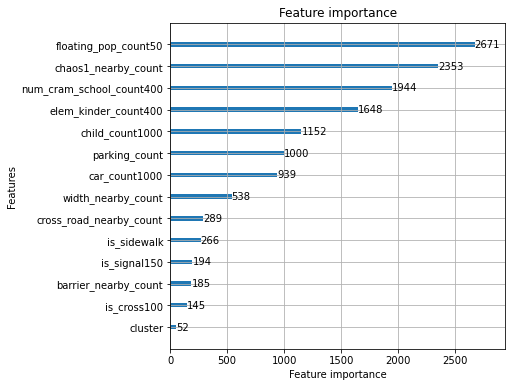

In [35]:
f, ax=plt.subplots(figsize=(6,6))
plot_importance(lgb_my_model, max_num_features=15, ax=ax) 

## f1 score 비교

In [36]:
print('best score : {0:.4f}'.format(xgb_grid.best_score_))
print(f1_score(y_test, xgb_pred, average=None))

print('best score : {0:.4f}'.format(xgb_my_grid.best_score_))
print(f1_score(y_test, xgb_my_pred, average=None))

print('best score : {0:.4f}'.format(lgb_grid.best_score_))
print(f1_score(y_test, lgb_pred, average=None))

print('best score : {0:.4f}'.format(lgb_my_grid.best_score_))
print(f1_score(y_test, lgb_my_pred, average=None))

best score : 0.2157
[0.96580027 0.23469388]
best score : 0.1715
[0.97939068 0.22033898]
best score : 0.1866
[0.96982074 0.24      ]
best score : 0.1576
[0.94476812 0.18556701]


In [37]:
confusion_matrix(y_test, xgb_pred)

array([[2118,  114],
       [  36,   23]], dtype=int64)

In [38]:
confusion_matrix(y_test, xgb_my_pred)

array([[2186,   46],
       [  46,   13]], dtype=int64)

In [39]:
confusion_matrix(y_test, lgb_pred)

array([[2137,   95],
       [  38,   21]], dtype=int64)

In [40]:
confusion_matrix(y_test, lgb_my_pred)

array([[2027,  205],
       [  32,   27]], dtype=int64)

### cut-off 조정

In [41]:
X_test_xgb=X_test.drop(['cluster'], axis=1)
X_my_test_xgb=X_my_test.drop(['cluster'], axis=1)

In [42]:
xgb_pred2 = (xgb_model.predict_proba(X_test_xgb)[:,1]>=0.7).astype(int)
print('f1 score:', f1_score(y_test, xgb_pred2))

confusion_matrix(y_test, xgb_pred2)

f1 score: 0.2037037037037037


array([[2194,   38],
       [  48,   11]], dtype=int64)

In [43]:
xgb_my_pred2 = (xgb_my_model.predict_proba(X_my_test_xgb)[:,1]>=0.7).astype(int)
print('f1 score:', f1_score(y_my_test, xgb_my_pred2))

confusion_matrix(y_my_test, xgb_my_pred2)

f1 score: 0.1978021978021978


array([[2209,   23],
       [  50,    9]], dtype=int64)

In [44]:
lgb_pred2 = (lgb_model.predict_proba(X_test)[:,1]>=0.7).astype(int)
print('f1 score:', f1_score(y_test, lgb_pred2))

confusion_matrix(y_test, lgb_pred2)

f1 score: 0.2711864406779661


array([[2189,   43],
       [  43,   16]], dtype=int64)

In [45]:
lgb_my_pred2 = (lgb_my_model.predict_proba(X_my_test)[:,1]>=0.7).astype(int)
print('f1 score:', f1_score(y_my_test, lgb_my_pred2))

confusion_matrix(y_my_test, lgb_my_pred2)

f1 score: 0.2138364779874214


array([[2149,   83],
       [  42,   17]], dtype=int64)

## 위험구역 from xgb

In [46]:
xgb_pred_prob = xgb_model.predict_proba(X_test_xgb)

danger_xgb=pd.DataFrame(xgb_pred_prob)
danger_xgb.columns=['No_xgb', 'Yes_xgb']

In [47]:
danger_xgb=pd.concat([data25, danger_xgb], axis=1)
danger_xgb_all=danger_xgb.sort_values(by=['Yes_xgb'], ascending=False)[0:40] #그냥 상위 40개

In [48]:
danger_xgb_without=danger_xgb[danger_xgb['overspeed_cam_count100']==0]
danger_xgb_without=danger_xgb_without.sort_values(by=['Yes_xgb'], ascending=False)[0:40] #카메라 없는 곳 상위 40개

In [49]:
import geopandas as gpd
import json
import folium
from folium import plugins

In [50]:
osan=gpd.read_file("C:/Users/ishon/OneDrive/바탕 화면/SIG_202005/SIG.shp")
osan=osan[osan["SIG_ENG_NM"]=="Osan-si"]
center = (37.1623799231016, 127.05436890115905)
style5 = {'fillColor': 'skyblue', 'color': 'skyblue'}

map_xgb_danger = folium.Map(location=center, zoom_start=12, width=900, height=700, control_scale=True)

#osan
osan_region = plugins.FeatureGroupSubGroup(map_xgb_danger, 'osan region')
map_xgb_danger.add_child(osan_region)
folium.GeoJson(osan, style_function=lambda x:style5).add_to(osan_region)

fg = folium.FeatureGroup(name='groups')
map_xgb_danger.add_child(fg)

g1 = plugins.FeatureGroupSubGroup(fg, 'group1')
map_xgb_danger.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'group2')
map_xgb_danger.add_child(g2)

danger_xgb_all.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                                radius=2, color='blue').add_to(g1), axis=1)

danger_xgb_without.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                               radius=2, color='red').add_to(g2), axis=1)

folium.LayerControl(collapsed=False).add_to(map_xgb_danger)
map_xgb_danger

## 위험구역 from lgb

In [51]:
lgb_pred_prob = lgb_model.predict_proba(X_test)

danger_lgb=pd.DataFrame(lgb_pred_prob)
danger_lgb.columns=['No_lgb', 'Yes_lgb']

In [52]:
danger_lgb=pd.concat([data25, danger_lgb], axis=1)
danger_lgb_all=danger_lgb.sort_values(by=['Yes_lgb'], ascending=False)[0:40]

In [53]:
danger_lgb_without=danger_lgb[danger_lgb['overspeed_cam_count100']==0]
danger_lgb_without=danger_lgb_without.sort_values(by=['Yes_lgb'], ascending=False)[0:40]

In [54]:
import geopandas as gpd
import json
import folium
from folium import plugins

In [55]:
osan=gpd.read_file("C:/Users/ishon/OneDrive/바탕 화면/SIG_202005/SIG.shp")
osan=osan[osan["SIG_ENG_NM"]=="Osan-si"]
center = (37.1623799231016, 127.05436890115905)
style5 = {'fillColor': 'skyblue', 'color': 'skyblue'}

map_lgb_danger = folium.Map(location=center, zoom_start=12, width=900, height=700, control_scale=True)

#osan
osan_region = plugins.FeatureGroupSubGroup(map_lgb_danger, 'osan region')
map_lgb_danger.add_child(osan_region)
folium.GeoJson(osan, style_function=lambda x:style5).add_to(osan_region)

fg = folium.FeatureGroup(name='groups')
map_lgb_danger.add_child(fg)

g1 = plugins.FeatureGroupSubGroup(fg, 'group1')
map_lgb_danger.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'group2')
map_lgb_danger.add_child(g2)

danger_lgb_all.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                                radius=2, color='blue').add_to(g1), axis=1)

danger_lgb_without.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                               radius=2, color='red').add_to(g2), axis=1)

folium.LayerControl(collapsed=False).add_to(map_lgb_danger)
map_lgb_danger